### Chile Inflation Nowcast
* This code is a first attempt as using the Cleveland Fed Nowcast Methodology to predict headline inflation
* https://www.clevelandfed.org/indicators-and-data/inflation-nowcasting
* Hope to expand it to include additional explanatory variables soon

In [223]:
#Import statements
import pandas as pd 
import numpy as np
import yfinance as yf
from matplotlib import pyplot as plt
from fredapi import Fred
from datetime import datetime
import statsmodels.api as sm
import config
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
fred = Fred(api_key=config.api_key)


In [224]:
#Get Exchange rate data and Energy price data from Yahoo Finance

# Define the ticker list
# Currently using the exchange rate and the Oil price
tickers_list = ['CLP=X','CL=F','BCH','MELI','FALABELLA.SN','COPEC.SN','CCU']

# Fetch the data
data = yf.download(tickers_list,'1990-1-1')['Adj Close']

#Organize the data for merging and convert to monthly % changes
dfyf = data.groupby(pd.PeriodIndex(data.index, freq="M"))[tickers_list].mean()
dfyf.reset_index(inplace=True)
dfyf['Date'] = dfyf['Date'].dt.strftime('%Y/%m/%d')
dfyf['Date'] = pd.to_datetime(dfyf['Date'])
dfyf['month'] = dfyf['Date'].dt.month
dfyf['year'] = dfyf['Date'].dt.year

#Merging dates start first day of month, so use that detail
dfyf['Date'] = dfyf['Date'].apply(lambda x: datetime(x.year, x.month, 1))
dfyf = dfyf.set_index('Date')

dfyf[tickers_list] = 100*dfyf[tickers_list].pct_change(3)

dfyf.head()

[*********************100%***********************]  7 of 7 completed


,CLP=X,CL=F,BCH,MELI,FALABELLA.SN,COPEC.SN,CCU,month,year
Date,,,,,,,,,
1992-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,1992
1992-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,1992
1992-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,1992
1992-12-01,NaN,NaN,NaN,NaN,NaN,NaN,11.521142,12,1992
1993-01-01,NaN,NaN,NaN,NaN,NaN,NaN,36.041023,1,1993


In [225]:
#Define function for collecting data from FRED
def fredget(varlist, start_date, end_date, plots=True,freq="",name_map = dict()):
    df_collect = pd.DataFrame()

    for var in varlist:
        df_add = fred.get_series(var, observation_start = start_date, observation_end=end_date, frequency =freq).to_frame(name = var)
        info_add = fred.get_series_info(var).to_frame(name = var)
        print(var)
        #If user changes the 
        if freq != "":
            info_add.loc['cur_freq', var] = freq
            
        if var in name_map:
            info_add.loc['user_title', var] = name_map[var]
        else:
            info_add.loc['user_title', var] = info_add.loc['title', var]
                    
        if plots == True:
            df_add.plot(y=var, use_index=True, kind='line', title = info_add.loc['user_title', var], ylabel = info_add.loc['units', var] )
            
        if df_collect.empty == True:
            df_collect = df_add
            info_store = info_add
        else:
            df_collect = pd.merge(df_collect, df_add, left_index=True, right_index=True, how='outer')
            info_store = pd.merge(info_store, info_add, left_index=True, right_index=True, how='left')
            
    df_collect.sort_index()
    return df_collect, info_store


In [226]:
#Define FRED codes to search for 
FRED_list = ['CPALTT01CLM657N','CPGREN01CLM657N','CPGRLE01CLM657N','WPUID61','PCOPPUSDM','BAA10Y','VIXCLS','CUSR0000SAD']

s_d ='1990-01-01'
e_d='2023-03-01'

#Collect variables into a monthly df
df_collect_m, dfinfo_m = fredget(FRED_list, s_d, e_d, freq = "m", plots=False)

#Convert this series to MoM % changes
df_collect_m['WPUID61'] = df_collect_m['WPUID61'].pct_change(3)*100
df_collect_m['PCOPPUSDM'] = df_collect_m['PCOPPUSDM'].pct_change(3)*100

CPALTT01CLM657N
CPGREN01CLM657N
CPGRLE01CLM657N
WPUID61
PCOPPUSDM
BAA10Y
VIXCLS
CUSR0000SAD


In [227]:
#Collect both the fred and Yahoo Finance Data
df = dfyf.merge(df_collect_m, how='inner',left_index=True,right_index=True)

#Rename columns
rename_cols = {"CPALTT01CLM657N":"headline","CPGREN01CLM657N":"energy","CPGRLE01CLM657N":"core","WPUID61":"USppi","PCOPPUSDM":"copper","CLP=X":"exrate","CL=F":"oil","CUSR0000SAD":"goods"}
df = df.rename(columns=rename_cols)
#generate Month dummy variables for seasonal effects
dummies = pd.get_dummies(df['month']).rename(columns=lambda x: 'M_' + str(x))
df = pd.concat([df, dummies], axis=1)

#This concludes the data collection

#### Plot the input series to get a sense of the info they contain

<AxesSubplot:>

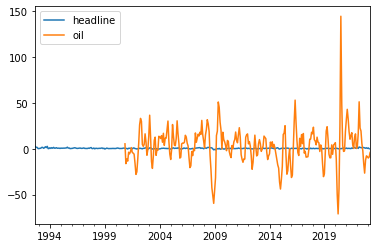

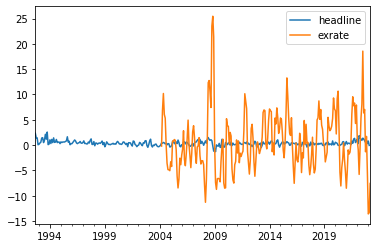

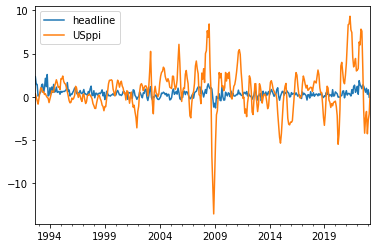

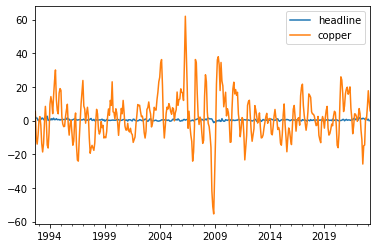

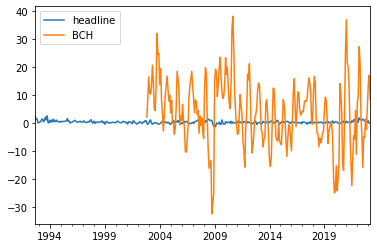

In [228]:
df[['headline','oil']].plot()
df[['headline','exrate']].plot()
df[['headline','USppi']].plot()
df[['headline','copper']].plot()
df[['headline','BCH']].plot()


In [229]:
#Generate forecasts as 12m avg of past values for certain variables + Generate Lags
df_setup = df
lag_list = ['core','headline','copper','oil','BCH']

for f in lag_list:
    reglist = list()
    for i in range(1,13):
        varname = f'{f}_L_{i}'
        reglist.append(varname)
        df_setup[varname] = df_setup[f].shift(i) 
    df_setup[f'{f}_fcast'] =  df_setup[reglist].mean(axis=1)
   

#Set the time period
df_setup = df_setup.loc['2008-01-01':'2023-01-01']

split_date = '2019-6-1'
df_train = df_setup.loc[df_setup.index <= split_date].copy()
df_test = df_setup.loc[df_setup.index > split_date].copy()


In [230]:
#Set the target
y = df_train['headline']
y_test = df_test['headline']

#AR1 baseline prediction
x_AR = df_train['headline_L_1']
x_AR = sm.add_constant(x_AR)

x_AR_test = df_test['headline_L_1']
x_AR_test= sm.add_constant(x_AR_test)

modelAR = sm.OLS(y, x_AR).fit()
#Get fitted values
df_train['fittedAR'] = modelAR.fittedvalues
df_test['fittedAR'] = modelAR.predict(x_AR_test)

modelAR.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               headline   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     28.40
Date:                Mon, 01 May 2023   Prob (F-statistic):           4.00e-07
Time:                        23:55:22   Log-Likelihood:                -56.689
No. Observations:                 138   AIC:                             117.4
Df Residuals:                     136   BIC:                             123.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1425      0.037      3.869      0.000       0.070       0.215
headline_L_1     0.4156      0.078      5.329      0.000       0.261       0.570
==============================================================================
Omnibus:                        8.232   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.016   Jarque-Bera (JB):               12.770
Skew:                          -0.261   Prob(JB):                      0.00169
Kurtosis:                       4.396   Cond. No.                         2.67
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [231]:
#Generate best regression predictions
x_set = ['oil','exrate','MELI','FALABELLA.SN','COPEC.SN','CCU','BCH_L_2','BCH_L_3','headline_L_1','USppi','M_3', 'M_9', 'M_11']

#Define x & y
x = df_train[x_set]
x = sm.add_constant(x)

x_test = df_test[x_set]
x_test = sm.add_constant(x_test)

#Fit to the training data 
OLSmodel = sm.OLS(y, x).fit()

#Get predicted values
df_train['fittedOLS'] = OLSmodel.fittedvalues
df_test['fittedOLS'] = OLSmodel.predict(x_test)

OLSmodel.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               headline   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     9.224
Date:                Mon, 01 May 2023   Prob (F-statistic):           4.44e-13
Time:                        23:55:22   Log-Likelihood:                -23.091
No. Observations:                 138   AIC:                             74.18
Df Residuals:                     124   BIC:                             115.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1472      0.040      3.670      0.000       0.068       0.227
oil              0.0018      0.002      0.763      0.447      -0.003       0.007
exrate           0.0258      0.007      3.901      0.000       0.013       0.039
MELI            -0.0006      0.001     -0.439      0.661      -0.003       0.002
FALABELLA.SN    -0.0004      0.004     -0.099      0.921      -0.009       0.008
COPEC.SN        -0.0002      0.004     -0.052      0.959      -0.008       0.008
CCU             -0.0002      0.004     -0.062      0.950      -0.008       0.007
BCH_L_2          0.0001      0.004      0.025      0.980      -0.008       0.009
BCH_L_3         -0.0040      0.004     -0.951      0.343      -0.012       0.004
headline_L_1     0.1471      0.085      1.736      0.085      -0.021       0.315
USppi            0.0715      0.016      4.431      0.000       0.040       0.103
M_3              0.2043      0.097      2.113      0.037       0.013       0.396
M_9              0.3497      0.098      3.579      0.000       0.156       0.543
M_11            -0.1534      0.103     -1.492      0.138      -0.357       0.050
==============================================================================
Omnibus:                        3.513   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.173   Jarque-Bera (JB):                3.384
Skew:                          -0.195   Prob(JB):                        0.184
Kurtosis:                       3.661   Cond. No.                         128.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/Users/wcrossb/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/wcrossb/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

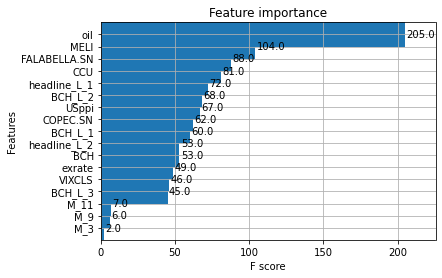

In [232]:
#Fit the XGB model here
x_set = ['oil','MELI','FALABELLA.SN','COPEC.SN','CCU','BCH','BCH_L_1','BCH_L_2','BCH_L_3','headline_L_1','headline_L_2','VIXCLS','exrate','USppi','M_3', 'M_9', 'M_11']

xgb_laglist = []
for var in xgb_laglist:
       add_list =df.filter(like=var).columns.to_list()
       x_set = x_set + add_list

#x_set.remove('headline')

#Define x & y
x = df_train[x_set]
x_test = df_test[x_set]

reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(x, y, eval_set=[(x, y), (x_test, y_test)],eval_metric='rmse', early_stopping_rounds=200, verbose=False) # Change verbose to True if you want to see it train

df_test['fittedXGB'] = reg.predict(x_test)

plot_importance(reg, height=2,max_num_features=20)


AR(1) MSE: 0.2179 ----- MAE: 0.3536
OLS MSE: 0.2046 ----- MAE: 0.3584
XGBoost MSE: 0.2394 ----- MAE: 0.4002
3 Model Avg. Pred MSE: 0.1887 ----- MAE: 0.3502


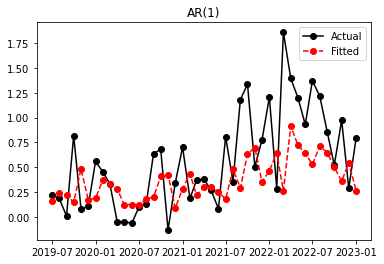

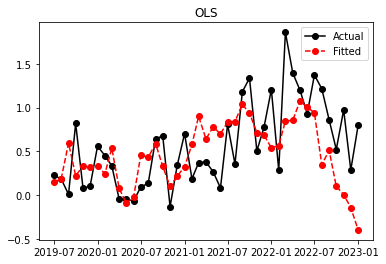

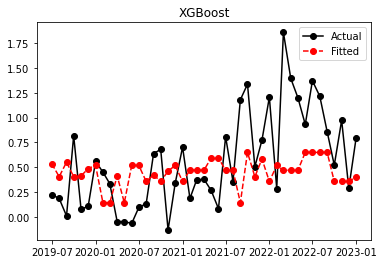

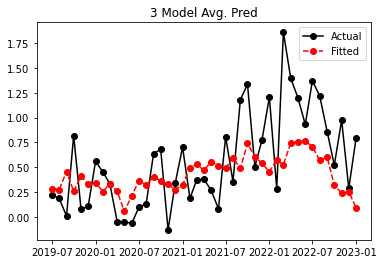

In [233]:
#Present a model summary Comparison
df_test['avgfit'] =  df_test[['fittedAR','fittedOLS','fittedXGB']].mean(axis=1)

model_specs = {'AR(1)':'fittedAR','OLS':'fittedOLS','XGBoost':'fittedXGB','3 Model Avg. Pred':'avgfit'}

for model in model_specs:
    varname = model_specs[model]
    plt.figure()
    plt.plot(df_test['headline'],'k',label ='Actual',marker='o')
    plt.plot(df_test[varname],color='r',linestyle='dashed', marker='o',
     markerfacecolor='red', label ='Fitted')
    plt.title(model)
    plt.legend()
        
    MSE = mean_squared_error(df_test['headline'], df_test[varname]).round(4)
    MAE = mean_absolute_error(df_test['headline'], df_test[varname]).round(4)
    print(f'{model} MSE: {MSE} ----- MAE: {MAE}')


In [234]:
df_test['error'] = df_test['headline'] - df_test['avgfit']
df_test['abs_error'] = df_test['error'].apply(np.abs)
error_by_month = df_test.groupby(['year','month']).mean()[['headline','avgfit','error','abs_error']]
    
error_by_month.sort_values('abs_error', ascending=False).head(10)

headline    avgfit     error  abs_error
year month                                         
2022 3      1.860465  0.525449  1.335016   1.335016
     1      1.206399  0.453916  0.752483   0.752483
     11     0.973236  0.240516  0.732720   0.732720
2023 1      0.798326  0.089773  0.708553   0.708553
2021 9      1.180209  0.490141  0.690068   0.690068
2022 7      1.371653  0.705695  0.665958   0.665958
     4      1.395231  0.746625  0.648606   0.648606
     8      1.216173  0.570045  0.646128   0.646128
2021 10     1.336922  0.739582  0.597341   0.597341
2019 10     0.818474  0.257729  0.560745   0.560745